# [replace with some interesting title]
## Introduction

[-- replace here --] !!!!

## Wrangling and Exploring the Data

First we load the libraries that we need, which are tidyverse, tidymodels, and repr.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Now we want to download the data from the url. Since it is in .zip format we have to download it before unzipping and then using read_csv(). The file "audit_risk.csv" is the one with the data that we want to use to create our regression and classification.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
download.file(url, "audit_data.zip")
unzip("audit_data.zip")

audit_risk_data_main <- read_csv("audit_data/audit_risk.csv")
head(audit_risk_data_main, 3) ### show the first 3 rows of the data to see if it is tidy.

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0


We are determining risk through classification of new data, so it needs to be converted to a factor.

The data appears to be tidy. Each column is one variable, each row is one observation, and each cell has exactly one value. Therefore, we will not need to wrangle the data.

In [3]:
audit_risk_data_main <- mutate(audit_risk_data_main, Risk = as_factor(Risk))
head(audit_risk_data_main, 3)

Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0


Now that the main table has been loaded, we can separate it into the training and testing data sets. We set the seed so the split is the same everytime and then use initial_split to perform the split.

In [4]:
### SET THE SEED
set.seed(18)
### DO NOT CHANGE

audit_risk_data_split <- initial_split(audit_risk_data_main, prop = 2/3, strata = Risk)
audit_risk_data_training <- training(audit_risk_data_split)
audit_risk_data_testing <- testing(audit_risk_data_split)

## Visualizing the Training Data

We should examine the data to see possible trends. We can get rid of the columns that we will not be using and then calculate the mean, median, standard deviation, min, and max to get a general sense of the numbers.

In [8]:
audit_risk_data_training_predictors <- select(audit_risk_data_training, Sector_score, History, PARA_A, PARA_B, TOTAL, Money_Value) ### Select the predictors only

### Now we can calculate the mean, median, min, and max and combine them all into one tibble.

audit_risk_data_training_mean <- audit_risk_data_training_predictors %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "mean")

audit_risk_data_training_max <- audit_risk_data_training_predictors %>%
map_df(max, na.rm = TRUE) %>%
mutate(Stat = "max")

audit_risk_data_training_min <- audit_risk_data_training_predictors %>%
map_df(min, na.rm = TRUE) %>%
mutate(Stat = "min")

audit_risk_data_training_median <- audit_risk_data_training_predictors %>%
map_df(median, na.rm = TRUE) %>%
mutate(Stat = "median")

audit_risk_data_training_stdev <- audit_risk_data_training_predictors %>%
map_df(sd, na.rm = TRUE) %>%
mutate(Stat = "stdev")

audit_risk_data_training_stats <- bind_rows(audit_risk_data_training_max, audit_risk_data_training_mean,
                                            audit_risk_data_training_min, audit_risk_data_training_median,
                                            audit_risk_data_training_stdev)

audit_risk_data_training_stats

Sector_score,History,PARA_A,PARA_B,TOTAL,Money_Value,Stat
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
59.85000,9.0000000,85.000000,1264.63000,1268.91000,935.03000,max
19.51884,0.1138996,2.681024,11.24682,13.88798,17.35457,mean
1.85000,0.0000000,0.000000,0.00000,0.00000,0.00000,min
3.89000,0.0000000,0.845000,0.44000,1.35500,0.13000,median
24.10153,0.5567937,6.621520,58.97508,60.19784,80.31088,stdev


### Analyzing the table

In our table, the max values are very large in comparison to the mean and median.

When comparing the mean to the median, we notice that they are quite far apart. This could indicate that there are not many fraudulent bodies but there are some at the top with very large Money_Value and TOTAL values that raise the mean but do not affect the median by much.

The min indicates that every value except for Sector_score can be exactly zero.

<strong>In addition to calculating those stats, we should see how many observations have risk factors of 0 or 1, as well as the total observations.</strong>

In [9]:
audit_risk_data_count <- audit_risk_data_training %>%
group_by(Risk) %>%
summarize(n = n())

audit_risk_data_count

`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,314
1,204


There seems to about an even split, which is good because it will provide us with enough samples of each to accurately predict the Risk. The total number of observations in our training data is 518. This should be sufficient to be accurate.

### Creating a Plot

Based on the tables previously, I think it would be interesting to explore the distributions of Money_Value and Sector_score.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


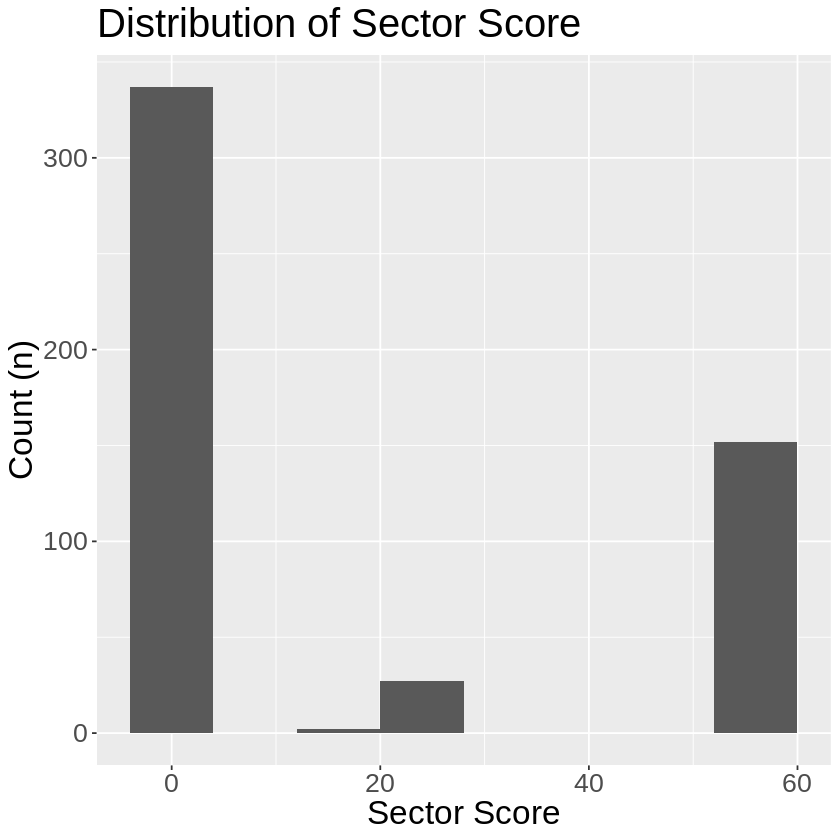

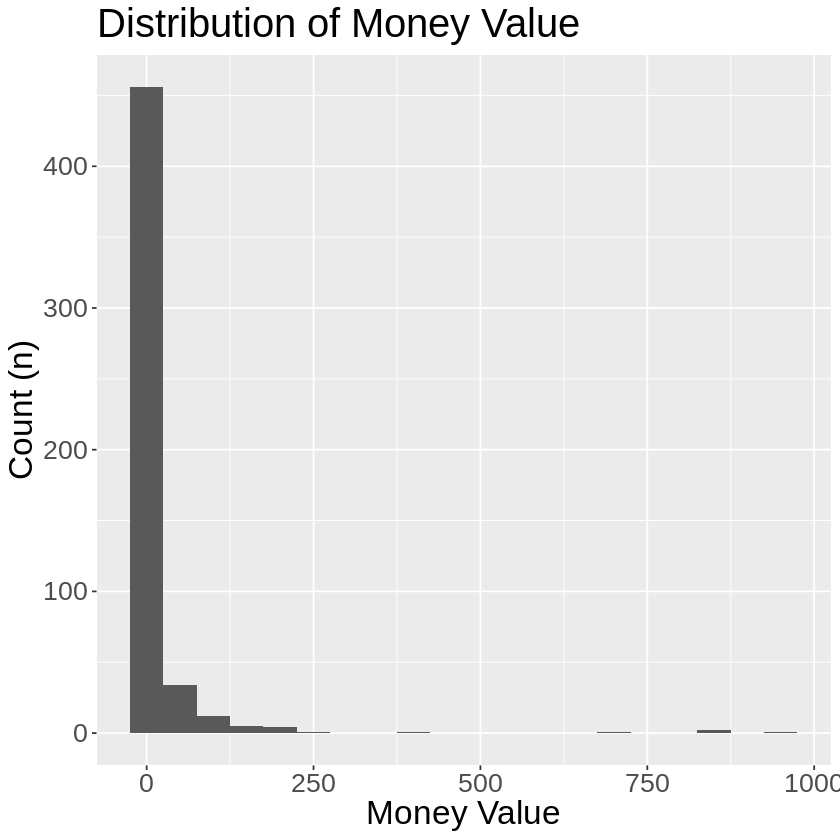

In [22]:
audit_risk_data_distributions_ss <- audit_risk_data_training_predictors %>%
ggplot(aes(x = Sector_score)) +
geom_histogram(binwidth = 8) +
theme(text = element_text(size = 20)) +
labs(x = "Sector Score", y = "Count (n)") +
ggtitle("Distribution of Sector Score")

audit_risk_data_distributions_mv <- audit_risk_data_training_predictors %>%
ggplot(aes(x = Money_Value)) +
geom_histogram(binwidth = 50) +
theme(text = element_text(size = 20)) +
labs(x = "Money Value", y = "Count (n)") +
ggtitle("Distribution of Money Value")

audit_risk_data_distributions_ss
audit_risk_data_distributions_mv

For the Sector Score plot, there is a large amount of Sector Scores around 0 and 60. This indicates that Sector_score is pretty polarized to either near the max or near the min. In the Money Value distribution, we see a very large amount of values near 0, and then small amounts of Money_Value values greater than 250. Both plots indicate outliers, with Money Value being more severe.

## Methods

[-- replace here --]

## Expected Outcomes and Significance

[-- replace here --]